# <span style="color:pink">Project part 2.5.5</span>

<span style="color:pink">**_Zofia Różańska, 280526_**</span>

<span style="color:pink">_Dataset: Estimation of Obesity Levels Based On Eating Habits and Physical Condition_</span>


In [27]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

In [29]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [30]:
# Load the dataset
dataset_url = 'https://raw.githubusercontent.com/zosia-r/msid/refs/heads/main/I/dataset.csv'
data = pd.read_csv(dataset_url)

# Display all columns and rows in the DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(data.head())

   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        

In [31]:
# Separate features and target
X = data.drop('NObeyesdad', axis=1)
y = data['NObeyesdad']

In [32]:
def preprocess(X):
    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Define the preprocessing steps for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    return preprocessor

In [33]:
# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [34]:
# Split data into trainig, validating and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [35]:
# Perform preprocessing on X
preprocessor = preprocess(X)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [36]:
class LogisticRegression:
    def __init__(self, input_dim, num_classes, lr=0.01):
        self.model = nn.Sequential(
            nn.Linear(input_dim, num_classes),
            nn.Softmax(dim=1)
        )
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        
    def log_loss(self, X, y):
        logits = self.model[0](X)
        loss = self.criterion(logits, y)
        return loss.item()
    
    def evaluate(self, val_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in val_loader:
                logits = self.model[0](x)
                preds = logits.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        accuracy = 100. * correct / total
        return accuracy

    def train(self, train_loader, val_loader, epochs=5):
        self.train_losses = []
        self.val_losses = []

        start_time = time.time()  # Start time for training
            
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0.0

            for x, y in train_loader:
                logits = self.model[0](x)
                loss = self.criterion(logits, y)
                loss.backward()
                self.model[0].weight.data -= self.lr * self.model[0].weight.grad.data  # Manually update weights
                self.model[0].bias.data -= self.lr * self.model[0].bias.grad.data  # Manually update bias

                self.model[0].weight.grad.data.zero_()  # Zero the gradients
                self.model[0].bias.grad.data.zero_()  # Zero the gradients
                total_loss += loss.item()


            # train loss
            avg_train_loss = total_loss / len(train_loader)
            self.train_losses.append(avg_train_loss)

            # val loss
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    logits_val = self.model[0](x_val)
                    val_loss += self.criterion(logits_val, y_val).item()
            avg_val_loss = val_loss / len(val_loader)
            self.val_losses.append(avg_val_loss)

            val_acc = self.evaluate(val_loader)
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1} | Current Loss: {loss.item():.4f} | Val Accuracy: {val_acc:.2f}%")

        end_time = time.time()
        total_training_time = end_time - start_time  # Time in seconds

        print(f"\nTraining completed in {total_training_time:.2f} seconds.")

    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        self.model.load_state_dict(torch.load(path))
        self.model.eval()

    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            logits = self.model[0](x)
            preds = logits.argmax(dim=1)
        return preds


In [37]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [38]:
# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # no cuda on my pc :(
print("Using device:", device)

Using device: cpu


In [39]:
# Create loaders
batch_size = 32

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

In [40]:
# Training the model
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_encoded))

model = LogisticRegression(input_dim, num_classes, lr=0.5)
model.train(train_loader, val_loader, epochs=1000)

Epoch 100 | Current Loss: 0.3494 | Val Accuracy: 90.05%
Epoch 200 | Current Loss: 0.2370 | Val Accuracy: 92.18%
Epoch 300 | Current Loss: 0.2386 | Val Accuracy: 91.94%
Epoch 400 | Current Loss: 0.0743 | Val Accuracy: 91.94%
Epoch 500 | Current Loss: 0.0773 | Val Accuracy: 92.89%
Epoch 600 | Current Loss: 0.1528 | Val Accuracy: 93.36%
Epoch 700 | Current Loss: 0.1357 | Val Accuracy: 92.89%
Epoch 800 | Current Loss: 0.1816 | Val Accuracy: 93.60%
Epoch 900 | Current Loss: 0.0822 | Val Accuracy: 93.36%
Epoch 1000 | Current Loss: 0.1342 | Val Accuracy: 93.13%

Training completed in 56.42 seconds.


Accuracy: 94.799%
Cross-entropy loss: 0.1791
Classification report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.96      0.96      0.96        55
      Normal_Weight       0.93      0.91      0.92        55
     Obesity_Type_I       0.98      0.94      0.96        69
    Obesity_Type_II       0.97      0.98      0.98        66
   Obesity_Type_III       1.00      1.00      1.00        68
 Overweight_Level_I       0.88      0.91      0.89        55
Overweight_Level_II       0.89      0.91      0.90        55

           accuracy                           0.95       423
          macro avg       0.94      0.95      0.95       423
       weighted avg       0.95      0.95      0.95       423



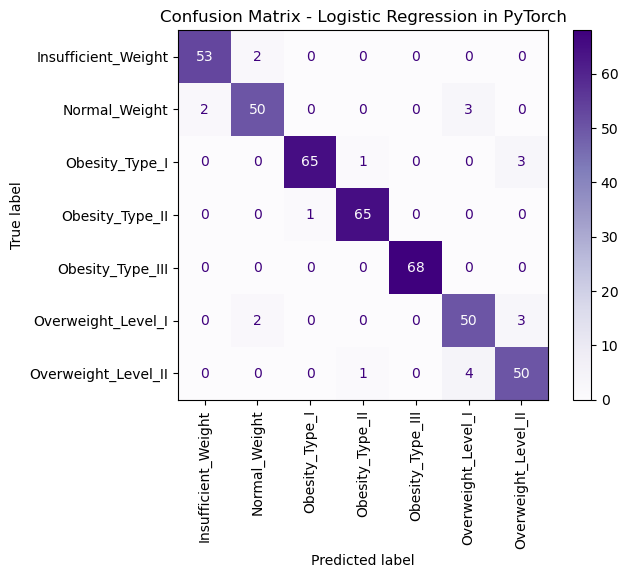

In [41]:
# Evaluate the model
y_pred = model.predict(X_test_tensor)

print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.3f}%')
print(f'Cross-entropy loss: {model.log_loss(X_test_tensor, y_test_tensor):.4f}')
print('Classification report:\n', classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90, cmap=plt.cm.Purples)
plt.title('Confusion Matrix - Logistic Regression in PyTorch')
plt.show()

In [42]:
# Evaluate on training set
y_train_pred = model.predict(X_train_tensor)

print(f'Training Accuracy: {accuracy_score(y_train, y_train_pred)*100:.3f}%')
print(f'Training Cross-entropy loss: {model.log_loss(X_train_tensor, y_train_tensor):.4f}')

Training Accuracy: 98.341%
Training Cross-entropy loss: 0.1032


# <span style="color:pink">Project part III</span>

## <span style="color:pink">Cross validation</span>

In [43]:
# from sklearn.model_selection import StratifiedKFold

# kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# accuracies = []

# # Prepare the data for K-Fold Cross-Validation
# X = preprocessor.transform(X)
# y_encoded = le.transform(y)

# for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
#     # Split the data
#     X_train_fold = torch.tensor(X[train_idx], dtype=torch.float32)
#     y_train_fold = torch.tensor(y_encoded[train_idx], dtype=torch.long)
#     X_val_fold = torch.tensor(X[val_idx], dtype=torch.float32)
#     y_val_fold = torch.tensor(y_encoded[val_idx], dtype=torch.long)

#     # DataLoaders
#     train_dataset = TensorDataset(X_train_fold, y_train_fold)
#     val_dataset = TensorDataset(X_val_fold, y_val_fold)
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#     # Train the model
#     clf_fold = LogisticRegression(input_dim=X.shape[1], num_classes=len(np.unique(y)), lr=0.01)
#     clf_fold.train(train_loader, val_loader, epochs=1000)

#     # Predict
#     y_val_pred = clf_fold.predict(X_val_fold).numpy()
#     acc = accuracy_score(y_encoded[val_idx], y_val_pred)
#     accuracies.append(acc)
#     print(f'Fold {fold + 1} accuracy: {acc * 100:.2f}%')

# # Mean accuracy
# print('-----')
# print('Mean accuracy (cross-val):', np.mean(accuracies)*100, '%')

## <span style="color:pink">Convergence plots and error anslysis</span>

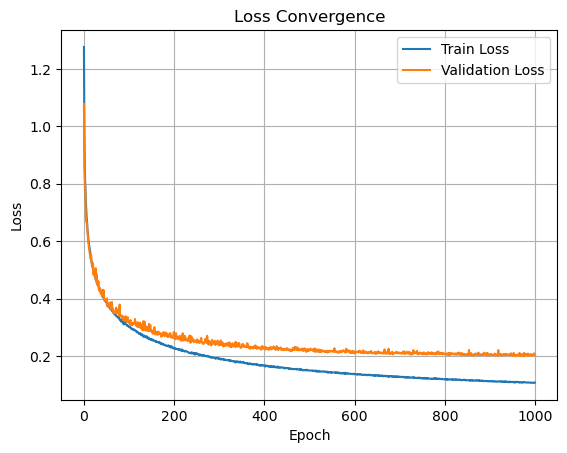

In [44]:
plt.plot(model.train_losses, label='Train Loss')
plt.plot(model.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.legend()
plt.grid(True)
plt.show()

Epoch 100 | Current Loss: 0.0076 | Val Accuracy: 91.48%
Epoch 200 | Current Loss: 0.0059 | Val Accuracy: 91.86%
Epoch 300 | Current Loss: 0.0041 | Val Accuracy: 91.48%
Epoch 400 | Current Loss: 0.0067 | Val Accuracy: 91.48%
Epoch 500 | Current Loss: 0.0098 | Val Accuracy: 91.48%
Epoch 600 | Current Loss: 0.0008 | Val Accuracy: 91.29%
Epoch 700 | Current Loss: 0.0053 | Val Accuracy: 91.29%
Epoch 800 | Current Loss: 0.0018 | Val Accuracy: 91.48%
Epoch 900 | Current Loss: 0.0003 | Val Accuracy: 91.48%
Epoch 1000 | Current Loss: 0.0013 | Val Accuracy: 91.48%

Training completed in 68.03 seconds.


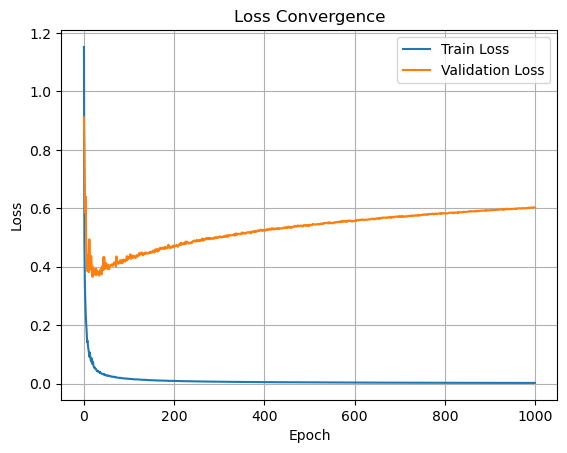

In [45]:
# Polynomial Features
from sklearn.preprocessing import PolynomialFeatures

X = data.drop('NObeyesdad', axis=1)
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, random_state=42)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

X_train = poly.fit_transform(X_train)
X_val = poly.fit_transform(X_val)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Training the model
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_encoded))


model = LogisticRegression(input_dim, num_classes, lr=0.5)
model.train(train_loader, val_loader, epochs=1000)

# Plot
plt.plot(model.train_losses, label='Train Loss')
plt.plot(model.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.legend()
plt.grid(True)
plt.show()
